In [4]:
import numpy as np
import time 
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C
from scipy.stats import qmc, norm
from scipy.optimize import minimize
from typing import Iterator, List, Tuple, Union

from science_jubilee.Machine import Machine
from science_jubilee.tools.Tool import Tool
from science_jubilee.decks.Deck import Deck
from science_jubilee.labware.Labware import Labware, Location, Well
from science_jubilee.tools.Pipette import Pipette
from science_jubilee.bo.newcamera import Cam

**Set the Deck, Labware, Camera, Pipette for manual experiment**

In [28]:
deck = Deck("lab_automation_deck") # We are not using the deck, so operate any deck.json 
tiprack = deck.load_labware(labware_filename = 'opentrons_96_tiprack_20ul.json', slot = 1)   # Load an opentrons 20uL
tiprack.manual_offset([[266, 209],[167, 209],[167, 272.1]], save = True)   # Save through list of list. List of coordinates should be A1 A12 H12 subsequently. 
trash = deck.load_labware('agilent_1_reservoir_290ml.json', 0)
samples = deck.load_labware('nest_96_wellplate_200ul_flat.json', slot = 2)
samples.manual_offset([[127.4, 115.4],[27.4, 115.4], [27.4, 178.4]], save = True)
stocks = deck.load_labware('corning_6_wellplate_16.8ml.json', slot = 3)
stocks.manual_offset([[256.8, 127.4], [178.8, 127.4], [178.8, 165.4]], save = True)
camera_well = deck.load_labware("cam_wellplate.json", slot = 2)

New manual offset applied to opentrons_96_tiprack_20ul
Manual offset saved
New manual offset applied to nest_96_wellplate_200ul_flat
Manual offset saved
New manual offset applied to corning_6_wellplate_16.8ml_flat
Manual offset saved


## **Connect Axo.Jubilee** ##

In [30]:
axo = Machine(address = "192.168.1.4")
axo.home_all()

In [31]:
axo.move_to(z=180)

In [32]:
deck = axo.load_deck("lab_automation_deck")
tip_rack = axo.load_labware("opentrons_96_tiprack_20ul", 1)
tiprack.load_manualOffset()
trash = axo.load_labware('agilent_1_reservoir_290ml.json', 1)
#pipette = Pipette(0, "Pipette", brand = "opentron", model = "config", max_volume= 20, min_volume= 0, zero_position = (0,0,0),\
#    blowout_position=None, drop_tip_position = None, mm_to_ul = None)# model = "config")
samples = axo.load_labware('nest_96_wellplate_200ul_flat.json', 2)
samples.load_manualOffset()
stocks = axo.load_labware('corning_6_wellplate_16.8ml.json', 3)
stocks.load_manualOffset()
camera_well = axo.load_labware("cam_wellplate.json", slot = 2)

New manual offset applied to opentrons_96_tiprack_20ul
New manual offset applied to nest_96_wellplate_200ul_flat
New manual offset applied to corning_6_wellplate_16.8ml_flat


In [33]:
# Load the camera tool, Pipette
P20 = Pipette.from_config(0, 'Pipette', 'P300_config.json')
camera = Cam(1, "Camera", '192.168.1.2', 'Sun92023', 'axo', 'C:/science-jubilee/axo/data', 50)

axo.load_tool(camera)
axo.load_tool(P20)
P20.add_tiprack(tiprack)
P20.trash = trash[0]

## **Color Demo ( BO )** ## 

## **Functions** ##


In [12]:
### Helper Functions
# Distance metric: Negative Euclidean distance between two RGB colors
def negative_distance(rgb1, rgb2):
    return -np.linalg.norm(np.array(rgb1) - np.array(rgb2))

# Visualization of selected colors
def visualize_color_selection(X_samples, target_color):
    n_samples = len(X_samples)
    colors_per_row = 10
    n_rows = (n_samples + colors_per_row - 1) // colors_per_row

    plt.figure(figsize=(12, n_rows * 1.2))
    for idx, rgb in enumerate(X_samples):
        row = idx // colors_per_row
        col = idx % colors_per_row

        plt.subplot(n_rows, colors_per_row, idx + 1)
        plt.imshow([[rgb / 255.0]], extent=[0, 1, 0, 1])
        plt.axis("off")
        plt.title(f"Iter {idx + 1}", fontsize=8)

    plt.tight_layout()
    plt.figure(figsize=(2, 2))
    plt.imshow([[target_color / 255.0]], extent=[0, 1, 0, 1])
    plt.axis("off")
    plt.title("Target Color", fontsize=12)
    plt.show()

# To visualize one color and target color 
def visualize_one_color(X_sample, target_color, index):
    plt.figure(figsize=(4, 2))
    
    # Plot the sample color
    plt.subplot(1, 2, 1)
    plt.imshow([[X_sample / 255.0]], extent=[0, 1, 0, 1])
    plt.axis("off")
    plt.title(f"Iter {index + 1}", fontsize=12)
    
    plt.subplot(1, 2, 2)
    plt.imshow([[target_color / 255.0]], extent=[0, 1, 0, 1])
    plt.axis("off")
    plt.title("Target Color", fontsize=12)
    plt.tight_layout()
    plt.show()

In [13]:
# Candidate generation methods
# Latin Hypercube Sampling
def latin_hypercube_sampling(n_samples, dim):
    sampler = qmc.LatinHypercube(d=dim)
    return qmc.scale(sampler.random(n_samples), 0, 255)

# Sobol Sampling
def sobol_sampling(n_samples, dim):
    sampler = qmc.Sobol(d=dim, scramble=True)
    return qmc.scale(sampler.random(n_samples), 0, 255)

# Orthogonal Sampling
def orthogonal_sampling(n_samples, dim):
    grid_size = int(np.ceil(n_samples ** (1 / dim)))
    coords = np.linspace(0, 255, grid_size)
    grid = np.meshgrid(*[coords for _ in range(dim)])
    samples = np.stack(grid, axis=-1).reshape(-1, dim)
    np.random.shuffle(samples)
    return samples[:n_samples]

In [14]:
### Define Parameters
hyperparameter = 0.1
threshold = 0.025
max_iterations = 10
n_initial_samples = 10  # Initial samples
n_candidates = 200  # Candidate samples per iteration
target_rgb = np.array([10, 157, 200])  # Target RGB color

### Bayesian Optimization Setup
# Define kernel explicitly

# UPDATE  REASONING FOR KERNEL SELECTION 
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=10.0, length_scale_bounds=(1e-3, 1e3)) + WhiteKernel()

# Surrogate Model
# Initialize Gaussian Process Regressor
gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-4, n_restarts_optimizer=10, normalize_y=True)

In [15]:
# Acquisition Function
# Expected Improvement maximizes implicitly
# ei[sigma == 0.0] = 0.0 VERIFY HOW EI WORKS IN THIS CODE
def expected_improvement(X, X_sample, y_sample, model):
    """Return the expected improvement.
    Arguments
    mu     -- The predictive mean at the test points.
    sigma -- The predictive standard deviation at
             the test points.
    ymax  -- The maximum observed value (so far).
    """
    mu, sigma = model.predict(X, return_std=True)

    optimal_sample = np.min(y_sample)

    with np.errstate(divide="ignore"):
        imp = mu - optimal_sample - hyperparameter
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0
    return ei.flatten()

# NOTE MAKE SURE WHY ALGORITHM IS NOT RESAMPLING at each ITERATION
# Function to propose the next sample point using Expected Improvement
# Make sure it doesn't resample the same x each iterations
def propose_location(acquisition, X_sample, y_sample, bounds, n_restarts=25):
    dim = X_sample.shape[1]

    def min_obj(x):
        return -acquisition(x.reshape(-1, dim), X_sample, y_sample, gp)

    # Starting points for optimization
    x0_list = np.random.uniform(0, 1, size=(n_restarts, dim))
    best_x, best_val = None, float("inf")
    for x0 in x0_list:
        res = minimize(min_obj, x0, bounds=bounds, method="L-BFGS-B")
        if res.fun < best_val:
            best_val = res.fun
            best_x = res.x
    return best_x

In [16]:
# Function to normalize RGB values
def normalize_rgb(rgb):
    return rgb / 255.0

# Function to denormalize RGB values
def denormalize_rgb(rgb):
    return (rgb * 255.0).astype(int)

## **Simulation** ##

c:\Users\titan\anaconda3\envs\axo\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\titan\anaconda3\envs\axo\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\titan\anaconda3\envs\axo\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\titan\anaconda3\envs\axo\Lib\site-packages\sklearn\gaus

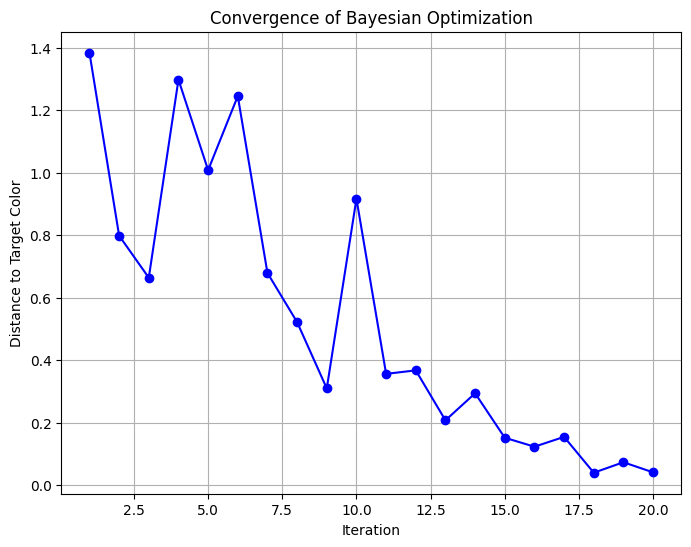

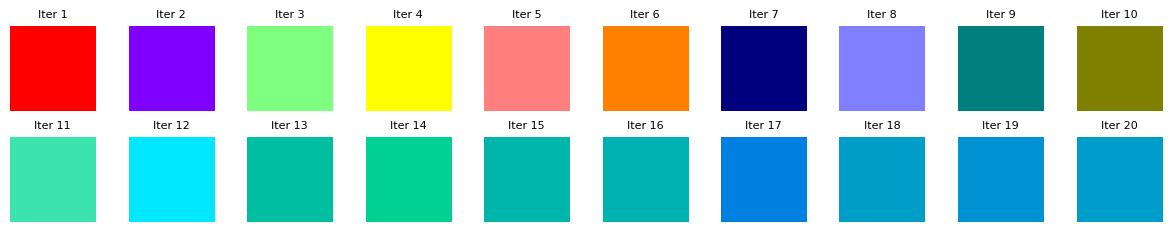

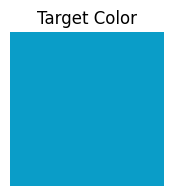

Optimal RGB: [  0 157 200]
Closest distance to target color: 1.3846747293545274


In [42]:
### Optimization Implementation and Visualization (GOOD)
# Bounds for RGB
bounds = [(0, 255)] * 3  # RGB values range between 0 and 255

# Normalize target color
normalized_target_rgb = normalize_rgb(target_rgb)

# Initialize initial samples and distances with normalized values
X_sample = normalize_rgb(orthogonal_sampling(n_initial_samples, 3))
y_sample = np.array([negative_distance(x, normalized_target_rgb) for x in X_sample])

# Run optimization loop
for iteration in range(max_iterations):
    # Propose the next location to sample
    next_sample = propose_location(expected_improvement, X_sample, y_sample, [(0, 1)] * 3)

    # Evaluate the objective function
    next_distance = negative_distance(next_sample, normalized_target_rgb)

    # Append the new sample and its objective value
    X_sample = np.vstack((X_sample, next_sample))
    y_sample = np.append(y_sample, next_distance)

    # Update the Gaussian Process model
    gp.fit(X_sample, y_sample)



# Denormalize results for visualization and display
X_sample_denorm = denormalize_rgb(X_sample)

# Visualization of results
# Plot convergence
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(y_sample) + 1), -y_sample, marker='o', linestyle='-', color='b')
plt.title('Convergence of Bayesian Optimization')
plt.xlabel('Iteration')
plt.ylabel('Distance to Target Color')
plt.grid(True)
plt.show()

# Visualize the final selected colors
target_rgb_denorm = denormalize_rgb(normalized_target_rgb)
visualize_color_selection(X_sample_denorm, target_rgb_denorm)

# Display final results
optimal_rgb = X_sample_denorm[np.argmin(-y_sample)]
print("Optimal RGB:", optimal_rgb)
print("Closest distance to target color:", -np.min(y_sample))

## **Interact with Physical World** ##

### **Convert to RGB to CYMK volume** ###

In [17]:
# Calculate from the results from decision maker (decision maker itself can provide this results)
def calculate_volumes_rgb(rgb_values, total_volume=200):
    """
    Calculate the volumes of Red, Green, and Blue solutions needed to achieve
    a target RGB color in a well with a given total volume.

    Parameters:
        rgb_values (np.array): A tuple of three integers representing the RGB values (R, G, B), each in the range 0-255.
        total_volume (float): The total volume of the well in microliters.

    Returns:
        dict: A dictionary with the calculated volumes for Red, Green, and Blue.
    """
    R, G, B = rgb_values
    total_rgb = R + G + B
    if total_rgb == 0:
        return {"Red": 0, "Green": 0, "Blue": 0}

    R_norm = R / total_rgb
    G_norm = G / total_rgb
    B_norm = B / total_rgb

    V_R = R_norm * total_volume
    V_G = G_norm * total_volume
    V_B = B_norm * total_volume

    return {"Red": V_R, "Green": V_G, "Blue": V_B}


def calculate_volumes_cmyk(rgb_values, total_volume=200):
    """
    Calculate the volumes of Cyan, Magenta, Yellow, and Black solutions needed to achieve
    a target RGB color in a well with a given total volume.

    Parameters:
        rgb_values (np.array): A tuple of three integers representing the RGB values (R, G, B), each in the range 0-255.
        total_volume (float): The total volume of the well in microliters.

    Returns:
        dict: A dictionary with the calculated volumes for Cyan, Magenta, Yellow, and Black.
    """
    
    if rgb_values.shape != (3,):
        raise ValueError(f"rgb_values must be a 1D NumPy array with three elements, got shape {rgb_values.shape}")
    R, G, B = rgb_values
    R, G, B = R / 255, G / 255, B / 255  # Normalize RGB values to [0, 1]

    # Convert RGB to CMY
    C = 1 - R
    M = 1 - G
    Y = 1 - B

    # Calculate the K (Black) component
    K = min(C, M, Y)

    # CMYK Percentage
    # Adjust CMY values based on K
    if K < 1:  # Avoid division by zero
        C = (C - K) / (1 - K)
        M = (M - K) / (1 - K)
        Y = (Y - K) / (1 - K)
    else:
        C = M = Y = 0

    # Calculate the normalized volumes
    total_cmyk = C + M + Y + K
    if total_cmyk == 0:
        return {"Cyan": 0, "Magenta": 0, "Yellow": 0, "Black": 0}

    C_norm = C / total_cmyk
    M_norm = M / total_cmyk
    Y_norm = Y / total_cmyk
    K_norm = K / total_cmyk

    # Calculate solution volumes
    V_C = round(C_norm * total_volume)
    V_M = round(M_norm * total_volume)
    V_Y = round(Y_norm * total_volume)
    V_K = round(K_norm * total_volume)

    return {"Cyan": V_C, "Magenta": V_M, "Yellow": V_Y, "Black": V_K}

# Example usage:
#rgb_values = (128, 64, 32)
rgb_values = np.array([192, 83, 2])  # Example RGB values
total_volume = 160  # Total volume in microliters
volumes = calculate_volumes_cmyk(rgb_values, total_volume)
print(volumes)

{'Cyan': 0, 'Magenta': 50, 'Yellow': 88, 'Black': 22}


## **List of volumes to each samples that overs 20uL** ##

In [19]:
# List of pipette to aspirate volume each samples that overs 20uL
def amount_to_aspirate(value):
    new_value = []
    while value > 0:
        if value > 20:
            value -= 20
            new_value.append(20)
        else:
            new_value.append(value)
            value = 0
            
    return new_value

## **Color Mixing + Optimization + Camera** ##

In [22]:
# Bounds for RGB
bounds = [(0, 255)] * 3  # RGB values range between 0 and 255

# Function to normalize RGB values
def normalize_rgb(rgb: np.ndarray):
    return rgb / 255.0

# Function to denormalize RGB values
def denormalize_rgb(rgb: np.ndarray):
    return (rgb * 255.0).astype(int)

# Define Pipette and stock movers as one function
def color_mover(volumes, target_well: Union[Well, Tuple, Location], tip_rack: List[Union[Well, Tuple, Location]]):
    """
    Dispenses color components (e.g., Cyan, Magenta, Yellow, Black) into the target well using a pipette.
    Makes One color well. 
    Args:
        volumes (dict): Dictionary specifying the volumes of each color component to be aspirated and dispensed.
                        Keys are color names (e.g., "Cyan", "Magenta", "Yellow", "Black"), and values are volumes (float).
        target_well (Union[Well, Tuple, Location]): The well where the mixed components will be dispensed.

    Returns:
        The function performs physical operations with no return value.
    """
    
    axo.pickup_tool(P20)
    
    stock_positions = {"Cyan": "A1", "Magenta": "A2", "Yellow": "A3", "Black": "B1"}
    
    # Define stock positions for Red, Green, Blue
    for idx, (color, volume) in enumerate(volumes.items()):
        
        if color == "Cyan":
            stock_position = stock_positions["Cyan"]
        elif color == "Magenta":
            stock_position = stock_positions["Magenta"]
        elif color == "Yellow":
            stock_position = stock_positions["Yellow"]
        else:
            stock_position = stock_positions["Black"]
        
        if volume > 0:
            P20.pickup_tip(tip_rack[idx])
        else:
            continue
        # If transfer doesn't work well, change to the previous one  
        # Verified it didn't work, moving back and forth to stocks and samples is not working  
        #P20.transfer(volume, stock_position, target_well.top(-4), blowout = True, new_tip = 'once', mix_after = )
        seperated_value = amount_to_aspirate(volume)
        
        for value in seperated_value:
            # We use the same stock colors at each iterations
            # Add aspiration function from the stock location
            P20.aspirate(vol = value, location = stocks[stock_position].bottom(9))
            # Add dispensing function to the well plate 
            P20.dispense(vol = value, location = target_well.top(-4), s = 3000)
            time.sleep(3)
            #P20.blowout(s = 3000) # Blowout keeps dropping the tips
        # Assign trash locations inside the class attribute (Later)    # HardCoded
        P20.drop_tip(trash[0])
        
    axo.park_tool()

def process_camera(camera_well: Union[Well, Tuple, Location]) -> Tuple[np.ndarray, np.ndarray]:
    """
    Captures an image from a specified well using the camera and extracts RGB values.

    Args:
        camera_well (Union[Well, Tuple, Location]): The well location to capture the image and extract RGB data.

    Returns:
        Tuple[np.ndarray, list]:
            - image (np.ndarray): The captured image as a NumPy array.
            - extract_rgb (list): List of dictionaries containing RGB values, e.g., [{"R": 120, "G": 200, "B": 150}].
    """
   
    axo.pickup_tool(camera)

    # Capture the image of the well
    image = camera.capture_image(camera_well, 'C:/science-jubilee/axo/bodata')
    
    masked_image, extract_rgb = camera.detect_and_draw_wells(image, 'C:/science-jubilee/axo/bodata')
    
    axo.park_tool()

    return image, extract_rgb

# color_mover + process_camera
# Attach Pipette and move to the stock and make samples according to the decision
def color_maker(rgb: np.ndarray, 
                sample_volume: float, 
                target_well: Union[Well, Tuple, Location], 
                camera_target_well: Union[Well, Tuple, Location], 
                tip_rack: List[Union[Well, Tuple, Location]]
                ) -> Tuple[np.ndarray, np.ndarray]:
    """
    Mixes colors based on the given RGB values, dispenses into the target well, and captures an image to analyze the resulting RGB.
    The Function performs color_mover and process_camera functionality.

    Args:
        rgb (np.ndarray): Normalized RGB values to mix. Shape: (3,).
        sample_volume (float): Total volume of the sample to be dispensed into the target well.
        target_well (Union[Well, Tuple, Location]): The well where the mixed color sample will be dispensed.
        camera_target_well (Union[Well, Tuple, Location]): The well location to capture and process RGB data using the camera.

    Returns:
        Tuple[np.ndarray, np.ndarray]:
            - image (np.ndarray): Captured image of the well after color mixing.
            - rgb_array (np.ndarray): Extracted and normalized RGB values from the image. Shape: (n_samples, 3).
    """
    
    volumes = calculate_volumes_cmyk(rgb, sample_volume)
    
    # Mix colors using the pipette       
    color_mover(volumes, target_well, tip_rack)
    
    # Capture circled masked image of resulting color in the well and extract rgb 
    masked_image, rgb_results = process_camera(camera_target_well)

    # Extract RGB values into a NumPy array
    rgb_array = np.array([[rgb['R'], rgb['G'], rgb['B']] for rgb in rgb_results]).reshape(-1)
    
    return masked_image, rgb_array

def decision_maker(target_rgb,
                   surrogate_model, 
                   acquisition_function,
                   sample_volume, 
                   X_sample, 
                   y_sample,
                   target_wells: List[Union[Well, Location, Tuple]],
                   camera_target_wells: List[Union[Well, Location, Tuple]],
                   tip_rack: List[List[Union[Well, Location, Tuple]]],
                   bounds=[(0, 1)] * 3, 
                   max_iterations = 10) -> Tuple[np.ndarray, np.ndarray]:
    """
    Perform multiple iterations of Bayesian Optimization, sampling different wells for each iteration.
    Args:
        target_rgb: Target RGB value to optimize towards. Target RGB should be normalized
        surrogate_model: Model called from the sklearn package (Gaussian Process Regressor)
        acquisition_function: The acquisition function to use for Bayesian Optimization.
        sample_volume: The sample volume for color mixing.
        X_sample: The current set of sample points.
        y_sample: The current set of objective values for the samples.
        target_wells: A list of target wells for each iteration.
        bounds: Bounds for the optimization space.
        max_iterations: Maximum number of iterations to perform.
    Returns:
        Updated X_sample and y_sample with all iterations completed.
    """
    
    assert len(target_wells) >= max_iterations, "Insufficient target wells for the given number of iterations."
    
    initial = len(X_sample)
    # Run optimization loop for all iterations
    for iteration in range(max_iterations):
        # Propose the next location to sample
        next_sample = propose_location(acquisition_function, X_sample, y_sample, bounds)
    
        # Denormalize next_sample to evaluate 
        next_sample_denorm = denormalize_rgb(next_sample)
        
        # Visualization for which color is sampled from acquuisition function
        visualize_one_color(next_sample_denorm, target_rgb, initial + iteration)
        
        # Get the target well for this iteration
        current_target_well = target_wells[iteration]
        current_camera_well = camera_target_wells[iteration]
        current_tipracks = tip_rack[iteration]
        
        # Make colors and extract actual RGB values
        image, rgb_val = color_maker(
            rgb=calculate_volumes_cmyk(next_sample_denorm), 
            sample_volume=sample_volume, 
            target_well=current_target_well,
            camera_target_well=current_camera_well,
            tip_rack=current_tipracks
        )
        
        # Normalize Acutal RGB Values
        rgb_val_normalized = normalize_rgb(rgb_val)
        
        # Evaluate the objective function (Simulation)
        next_distance = negative_distance(rgb_val_normalized, target_rgb)
        
        # Append the new sample and its objective value
        X_sample = np.vstack((X_sample, next_sample))
        y_sample = np.append(y_sample, next_distance)
    
        # Update the Gaussian Process model after all iterations
        surrogate_model.fit(X_sample, y_sample)
    
    return X_sample, y_sample


## Needs to modify for threshold handling
def one_decision_maker(target_rgb,
                       surrogate_model, 
                   acquisition_function,
                   sample_volume, 
                   X_sample, 
                   y_sample,
                   target_well: Union[Well, Location, Tuple],
                   camera_well: Union[Well, Location, Tuple], 
                   bounds = [(0, 1)] * 3):
    """
    Perform one step of Bayesian Optimization.
    Args:
        target_rgb: Target RGB value to optimize towards. Target RGB should be normalized
        surrogate_model: Model called from the sklearn package (Gaussian Process Regressor)
        acquisition_function: The acquisition function to use for Bayesian Optimization.
        sample_volume: The sample volume for color mixing.
        X_sample: The current set of sample points.
        y_sample: The current set of objective values for the samples.
        target_wells: A list of target wells for each iteration.
        bounds: Bounds for the optimization space.
        max_iterations: Maximum number of iterations to perform.
    Returns:
        Updated X_sample and y_sample with all iterations completed.
    """
    # Propose the next location to sample
    next_sample = propose_location(acquisition_function, X_sample, y_sample, bounds)

    # Denormalize next_sample to evaluate 
    next_sample_denorm = denormalize_rgb(next_sample)
        
    # Make colors and extract actual RGB values
    image, rgb_val = color_maker(calculate_volumes_cmyk(next_sample_denorm), 
                                 sample_volume = sample_volume,
                                 target_well = target_well,
                                 camera_target_well = camera_well)
        
    # Evaluate the objective function (Simulation)
    # Should it be normalized?
    rgb_val_normalized = normalize_rgb(rgb_val)
    
    next_distance = negative_distance(rgb_val_normalized, target_rgb)
        
    # Append the new sample and its objective value
    X_sample = np.vstack((X_sample, next_sample))
    y_sample = np.append(y_sample, next_distance)
    
    surrogate_model.fit(X_sample, y_sample)  # Update the model inside this function
    
    return X_sample, y_sample

### **Axo-Jubilee reads the locations from Labware class Well, Location, Tuple**  ###
### **Assign as dictionary for initial samples, additional iterations after intial samples, and maps them to samples and camera target location.** ###

In [37]:
# Assign all the labware for experimental settings 
def assign_wells_and_targets(max_iterations, n_initial_samples, tiprack: Well, samples: Well, camera_well : Well, plate_rows=8, plate_cols=12):
    """
    Assigns wells for initial samples, additional iterations after inital samples, 
    and maps them to samples target location and camera target location.
    Assigned Tipracks' value contains list of list as (initial_samples, 4)
    Args:
        max_iterations (int): Total number of iterations for the experiment.
        n_initial_samples (int): Number of initial samples.
        plate_rows (int): Number of rows in the plate layout (default: 8 for a 96-well plate).
        plate_cols (int): Number of columns in the plate layout (default: 12 for a 96-well plate).
        samples (dict): Mapping of well names to sample locations.
        camera_well (dict): Mapping of well names to camera locations.
    
    Returns:
        dict: A dictionary containing:
            - 'initial_wells': List of wells for initial samples.
            - 'additional_wells': List of wells for additional iterations.
            - 'target_wells': Combined list of all target wells.
            - 'well_targets': List of sample locations corresponding to target wells.
            - 'camera_targets': List of camera locations corresponding to target wells.
    """
    # Generate plate layout
    plate_layout = [f"{chr(row)}{col}" for row in range(ord('A'), ord('A') + plate_rows) for col in range(1, plate_cols + 1)]
    
    # Allocate wells for the first n_initial_samples
    initial_wells = plate_layout[:n_initial_samples]
    initial_tipracks_wells = plate_layout[:n_initial_samples*4]
    
    initial_tipracks = [
        [tiprack[well] for well in initial_tipracks_wells[i * 4:(i + 1) * 4]] 
        for i in range(n_initial_samples)
    ]
    initial_wells_target = [samples[well] for well in initial_wells] 
    initial_camera_wells_target = [camera_well[well] for well in initial_wells]
    
    # Assign remaining wells for iterations
    additional_tipracks_wells = plate_layout[len(initial_tipracks_wells):(len(initial_tipracks_wells) + max_iterations*4)]
    additional_wells = plate_layout[len(initial_wells):(len(initial_wells) + max_iterations)]
    
    # Map to well targets and camera targets
    additional_tipracks = [
        [tiprack[well] for well in additional_tipracks_wells[i * 4:(i + 1) * 4]] 
        for i in range(max_iterations)
    ]
    well_targets = [samples[well] for well in additional_wells] if samples else []
    camera_targets = [camera_well[well] for well in additional_wells] if camera_well else []
    
    return {
        'initial_tipracks': initial_tipracks,
        'initial_wells': initial_wells_target,
        'initial_camera_wells': initial_camera_wells_target,
        'additional_tipracks': additional_tipracks,
        'well_targets': well_targets,
        'camera_targets': camera_targets
    }

# Example
#max_iterations = 10
#n_initial_samples = 10
#sample_volume = 160
#target_rgb = np.array([10, 157, 200]) 

#result = assign_wells_and_targets(max_iterations, n_initial_samples, tiprack= tiprack, samples = samples, camera_well = camera_well)

#print(result['initial_tipracks'][1])
#for idx in range(10):
#    initial_tipracks = result['initial_tipracks'][idx]
#    for j in range(4):
#        print("-----------------")
#        print(initial_tipracks[j])

In [ ]:
#------------------ Not Used ---------------------#
def generate_strings_row_well():
    strings = [[f"{chr(letter)}{number}" for letter in range(ord('A'), ord('H') + 1)] for number in range(1, 13)]
    return strings

def generate_strings_column_well():
    strings = [[f"{chr(letter)}{number}" for number in range(1, 13)] for letter in range(ord('A'), ord('H') + 1)]
    return strings

# Row string list of list:
row_wise = generate_strings_row_well()
column_wise = generate_strings_column_well()
#------------------ Not Used ---------------------#

# **Demo-Run Color-Mixing Bayesian Optimization** #

In [23]:
### Initialize stocks and define parameters
hyperparameter = 0.1
threshold = 0.025
max_iterations = 10 # BO iterations
n_initial_samples = 10  # Initial samples
n_candidates = 200  # Candidate samples per iteration
sample_volume = 160 # Volume of Samples for each wells
target_rgb = np.array([300, 157, 200])  # Target RGB color

In [30]:
### Bayesian Optimization Setup
# Define kernel explicitly
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=10.0, length_scale_bounds=(1e-3, 1e3)) + WhiteKernel()

# Surrogate Model
# Initialize Gaussian Process Regressor
gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-4, n_restarts_optimizer=10, normalize_y=True)

# Acquisition Function
# Expected Improvement maximizes implicitly
def expected_improvement(X, X_sample, y_sample, model):
    """Return the expected improvement.
    Arguments
    mu     -- The predictive mean at the test points.
    sigma -- The predictive standard deviation at
             the test points.
    ymax  -- The maximum observed value (so far).
    """
    mu, sigma = model.predict(X, return_std=True)

    optimal_sample = np.min(y_sample)

    with np.errstate(divide="ignore"):
        imp = mu - optimal_sample - hyperparameter
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0
    return ei.flatten()

# Function to propose the next sample point using Expected Improvement
def propose_location(acquisition, X_sample, y_sample, bounds, n_restarts=25):
    dim = X_sample.shape[1]

    def min_obj(x):
        return -acquisition(x.reshape(-1, dim), X_sample, y_sample, gp)

    # Starting points for optimization
    x0_list = np.random.uniform(0, 1, size=(n_restarts, dim))
    best_x, best_val = None, float("inf")
    for x0 in x0_list:
        res = minimize(min_obj, x0, bounds=bounds, method="L-BFGS-B")
        if res.fun < best_val:
            best_val = res.fun
            best_x = res.x
    return best_x

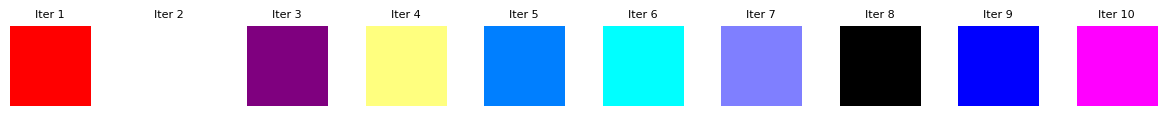

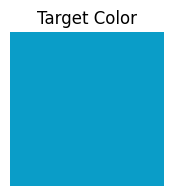

In [31]:
# Initialize initial samples and distances with normalized values
X_sample = normalize_rgb(orthogonal_sampling(n_initial_samples, 3))
y_sample = np.zeros(n_initial_samples)

# Combine initial and additional wells
all_wells = assign_wells_and_targets(max_iterations, n_initial_samples, samples = samples, camera_well = camera_well, tiprack= tiprack)

visualize_color_selection(denormalize_rgb(X_sample), target_rgb)

In [45]:
# Run the colormixing for initial samples
results = {}
for idx, x_sample in enumerate(X_sample): 
    #cmyk_volumes = calculate_volumes_cmyk(x_sample, sample_volume)
    
    target_well = all_wells['initial_wells'][idx]
    camera_target_well = all_wells['initial_camera_wells'][idx]
    initial_tipracks = all_wells['initial_tipracks'][idx]
    
    # Visualize the sampled color for each iterations
    visualize_one_color(denormalize_rgb(x_sample), target_rgb, idx)
    
    print(f"Picking up tipracks from : {initial_tipracks}")
    print(f"Now aspirating Sample{idx+1} to target_well : {target_well}")
    
    # Need to check
    image, rgb = color_maker(x_sample, sample_volume, target_well, camera_target_well, initial_tipracks)
    
    rgb_val_normalized = normalize_rgb(rgb)
    cmyk_volumes = calculate_volumes_cmyk(rgb)
    
    next_distance = negative_distance(rgb_val_normalized, target_rgb)
    y_sample[idx] = next_distance
    
    # Save to dictionary
    results[f"Sample {idx+1}"] = {
        "CMYK" : cmyk_volumes,
        "RGB" : x_sample,
        "Real_RGB"  : rgb,
        "Distance" : next_distance
    }

Picking up tipracks from : [Well A1 form Opentrons OT-2 96 Tip Rack 20 µL on slot 1, Well A2 form Opentrons OT-2 96 Tip Rack 20 µL on slot 1, Well A3 form Opentrons OT-2 96 Tip Rack 20 µL on slot 1, Well A4 form Opentrons OT-2 96 Tip Rack 20 µL on slot 1]
Now aspirating Sample1 to target_well : Well A1 form NEST 96 Well Plate 200 µL Flat on slot 2
Picking up tipracks from : [Well A5 form Opentrons OT-2 96 Tip Rack 20 µL on slot 1, Well A6 form Opentrons OT-2 96 Tip Rack 20 µL on slot 1, Well A7 form Opentrons OT-2 96 Tip Rack 20 µL on slot 1, Well A8 form Opentrons OT-2 96 Tip Rack 20 µL on slot 1]
Now aspirating Sample2 to target_well : Well A2 form NEST 96 Well Plate 200 µL Flat on slot 2
Picking up tipracks from : [Well A9 form Opentrons OT-2 96 Tip Rack 20 µL on slot 1, Well A10 form Opentrons OT-2 96 Tip Rack 20 µL on slot 1, Well A11 form Opentrons OT-2 96 Tip Rack 20 µL on slot 1, Well A12 form Opentrons OT-2 96 Tip Rack 20 µL on slot 1]
Now aspirating Sample3 to target_well : W

ValueError: rgb_values must be a 1D NumPy array with three elements, got shape (0,)

In [ ]:
# Perform Bayesian optimization in defined iterations
X_sample, y_sample = decision_maker(target_rgb, 
                                    surrogate_model = gp, 
                                    acquisition_function = expected_improvement,
                                    sample_volume = sample_volume, 
                                    X_sample = X_sample, 
                                    y_sample = y_sample,
                                    target_well = all_wells['well_targets'],
                                    camera_target_wells = all_wells['camera_targets'], 
                                    bounds = [(0, 1)] * 3)

In [27]:
# Results


KeyError: -1